# **Dinner Date with Data: Recommending Recipes with PySpark**
Contributors
- [Ahmed](https://github.com/ahmedembeddedx)
- [Ibtehaj](https://github.com/Ibtehaj778)
- Maira

### **GPU & PySpark Packages**

In [ ]:
!pip install pyspark
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com --no-cache-dir

### **Necessary Libraries**

In [54]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, _convert_to_vector
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import regexp_replace, col, monotonically_increasing_id
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
import cudf
import cupy as cp
from cuml.metrics import pairwise_distances
from termcolor import colored

import nltk
nltk.download('wordnet')
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import HTML


from tqdm import tqdm
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Spark Session**

In [66]:
spark = SparkSession.builder \
    .appName("Recipes Recommender") \
    .getOrCreate()

### **Spark Dataframe**

In [68]:
file_url = 'recipes_combined.csv'
df = spark.read.csv(file_url, header=True, inferSchema=True, encoding='utf-8', mode='FAILFAST')
df = df.select('recipeNames', 'all_ingredients')

In [69]:
df.show(5)

+--------------------+--------------------+
|         recipeNames|     all_ingredients|
+--------------------+--------------------+
|Poppy Seed Bread ...|Poppy Seed Bread ...|
|Czech Christmas H...|Czech Christmas H...|
|  Applesauce Bread I|Applesauce Bread ...|
|  Raisin Brown Bread|Raisin Brown Brea...|
|Applesauce Raisin...|Applesauce Raisin...|
+--------------------+--------------------+
only showing top 5 rows



In [70]:
df.printSchema()

root
 |-- recipeNames: string (nullable = true)
 |-- all_ingredients: string (nullable = true)



In [71]:
df = df.na.drop()

In [72]:
df.count()

9999

### **Text Cleaning**

In [73]:
def remove_numbers_and_punctuation(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('/', '').replace('  ', ' ').strip()
    return text

remove_numbers_and_punctuation_udf = udf(remove_numbers_and_punctuation, StringType())

df = df.withColumn('all_ingredients', remove_numbers_and_punctuation_udf(df['all_ingredients']))

In [74]:
df.show(5)

+--------------------+--------------------+
|         recipeNames|     all_ingredients|
+--------------------+--------------------+
|Poppy Seed Bread ...|Poppy Seed Bread ...|
|Czech Christmas H...|Czech Christmas H...|
|  Applesauce Bread I|Applesauce Bread ...|
|  Raisin Brown Bread|Raisin Brown Brea...|
|Applesauce Raisin...|Applesauce Raisin...|
+--------------------+--------------------+
only showing top 5 rows



### **Assigning uniqueID to all recipes**

In [75]:
df = df.withColumn('recipe_id', monotonically_increasing_id())

In [76]:
df.show(5)

+--------------------+--------------------+---------+
|         recipeNames|     all_ingredients|recipe_id|
+--------------------+--------------------+---------+
|Poppy Seed Bread ...|Poppy Seed Bread ...|        0|
|Czech Christmas H...|Czech Christmas H...|        1|
|  Applesauce Bread I|Applesauce Bread ...|        2|
|  Raisin Brown Bread|Raisin Brown Brea...|        3|
|Applesauce Raisin...|Applesauce Raisin...|        4|
+--------------------+--------------------+---------+
only showing top 5 rows



### **Word Cloud**

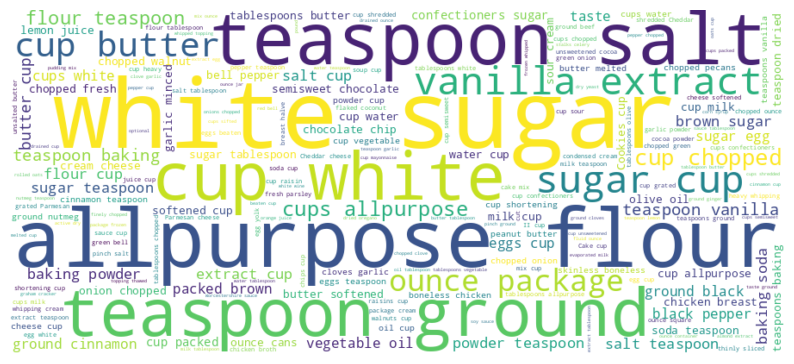

In [77]:
all_ingredients_text = ' '.join(df.select('all_ingredients').rdd.flatMap(lambda x: x).collect())

wordcloud = WordCloud(width=900, height=400, background_color='white').generate(all_ingredients_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### **Word Frequency Chart**

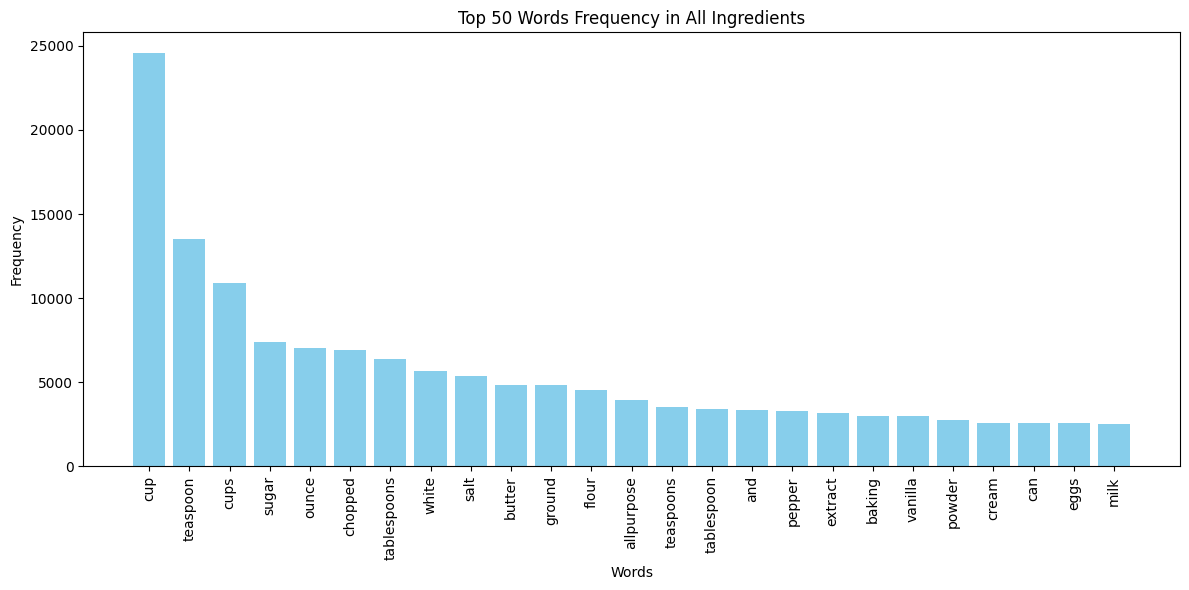

In [78]:
words = all_ingredients_text.split()

word_freq = Counter(words)

top_words = word_freq.most_common(25)

words, frequencies = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(range(len(words)), frequencies, tick_label=words, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Words Frequency in All Ingredients')
plt.tight_layout()
plt.show()

### **Heatmap**

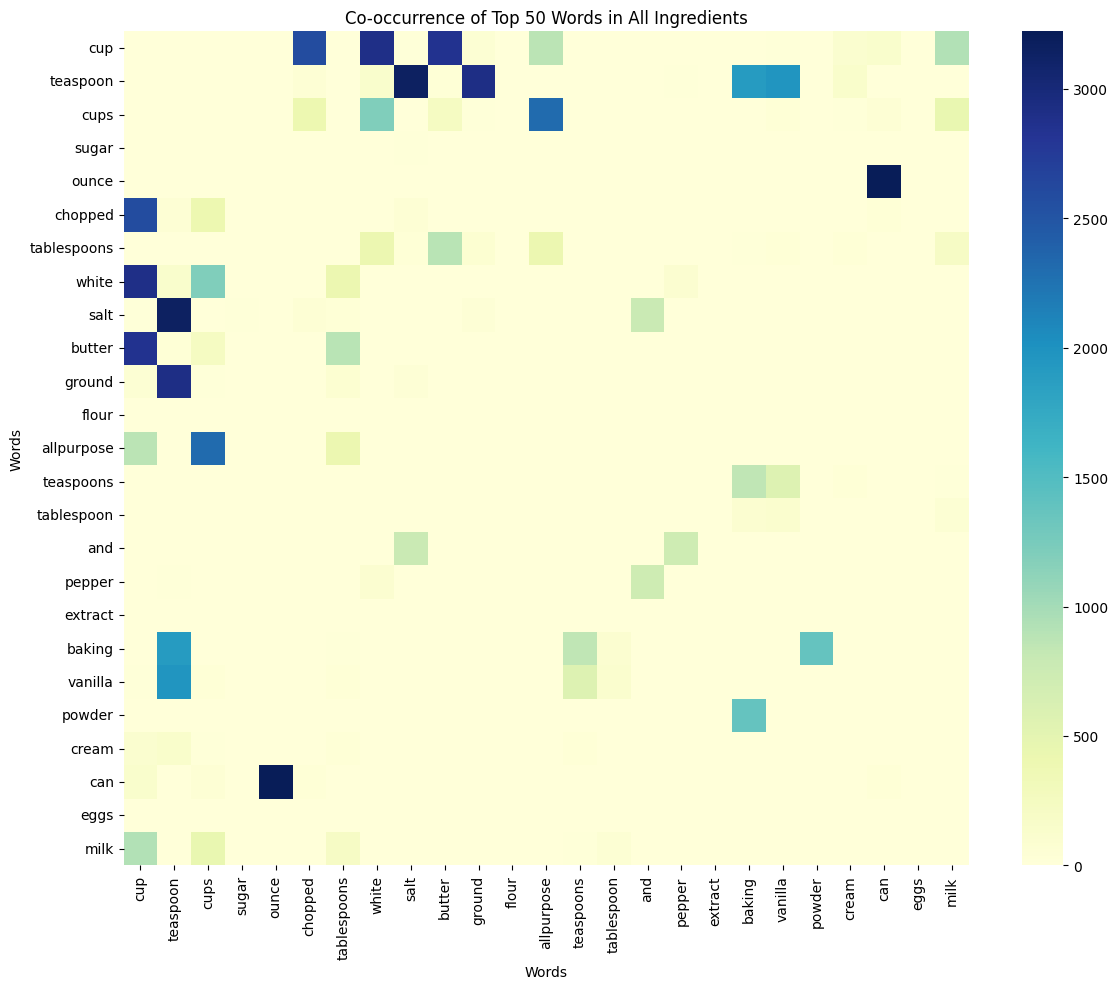

In [79]:
co_occurrence_matrix = [[0]*len(words) for _ in range(len(words))]

for i in range(len(words)):
    for j in range(i, len(words)):
        pair = (words[i], words[j])
        count = all_ingredients_text.count(' '.join(pair))
        co_occurrence_matrix[i][j] = count
        co_occurrence_matrix[j][i] = count

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=False, fmt="d", xticklabels=words, yticklabels=words, cmap="YlGnBu")
plt.title('Co-occurrence of Top 50 Words in All Ingredients')
plt.xlabel('Words')
plt.ylabel('Words')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### **NL Processing Pipeline**

In [80]:
class Lemmatizer(Transformer):
    def __init__(self, inputCol, outputCol):
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.lemmatizer = WordNetLemmatizer()

    def _transform(self, df):
        lemmatize_udf = udf(lambda tokens: [self.lemmatizer.lemmatize(token) for token in tokens], ArrayType(StringType()))
        return df.withColumn(self.outputCol, lemmatize_udf(df[self.inputCol]))


tokenizer = RegexTokenizer(inputCol="all_ingredients", outputCol="tokens", pattern="\\W")
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
lemmatizer = Lemmatizer(inputCol="filtered_tokens", outputCol="lemmatized_tokens")
count_vectorizer = CountVectorizer(inputCol="lemmatized_tokens", outputCol="rawFeatures")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, lemmatizer, count_vectorizer])

pipeline_model = pipeline.fit(df)

preprocessed_df = pipeline_model.transform(df)

In [81]:
preprocessed_df.show(5)

+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|         recipeNames|     all_ingredients|recipe_id|              tokens|     filtered_tokens|   lemmatized_tokens|         rawFeatures|
+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|Poppy Seed Bread ...|Poppy Seed Bread ...|        0|[poppy, seed, bre...|[poppy, seed, bre...|[poppy, seed, bre...|(4177,[0,1,2,4,6,...|
|Czech Christmas H...|Czech Christmas H...|        1|[czech, christmas...|[czech, christmas...|[czech, christmas...|(4177,[0,1,2,3,4,...|
|  Applesauce Bread I|Applesauce Bread ...|        2|[applesauce, brea...|[applesauce, brea...|[applesauce, brea...|(4177,[0,1,4,6,9,...|
|  Raisin Brown Bread|Raisin Brown Brea...|        3|[raisin, brown, b...|[raisin, brown, b...|[raisin, brown, b...|(4177,[0,1,2,4,6,...|
|Applesauce Raisin...|Applesauce R

In [82]:
preprocessed_df.printSchema()

root
 |-- recipeNames: string (nullable = true)
 |-- all_ingredients: string (nullable = true)
 |-- recipe_id: long (nullable = false)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lemmatized_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)



### **Performing Centroid Cosine Similarity through Vectors**
#### Using on the fly approach due to computational constraints and GPU resources, will try to shift it to cuda or mps for fast processing

In [22]:
!nvidia-smi

Sun May 12 12:53:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [60]:
def find_best_recipes(recipe_id):
    preprocessed_df_pd = preprocessed_df.toPandas()

    raw_features_entry1 = preprocessed_df_pd.loc[recipe_id, 'rawFeatures']

    if hasattr(raw_features_entry1, 'toArray'):
        entry1 = cp.array(raw_features_entry1.toArray()).reshape(1, -1)
    else:
        entry1 = cp.array(raw_features_entry1).reshape(1, -1)

    similarities = []

    total_rows = len(preprocessed_df_pd)
    for i in tqdm(range(total_rows), desc="Calculating Similarities"):
        raw_features_entry2 = preprocessed_df_pd.loc[i, 'rawFeatures']
        if hasattr(raw_features_entry2, 'toArray'):
            entry2 = cp.array(raw_features_entry2.toArray()).reshape(1, -1)
        else:
            entry2 = cp.array(raw_features_entry2).reshape(1, -1)

        distance = pairwise_distances(entry1, entry2, metric='cosine')
        similarity = 1 - distance

        similarities.append((i, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)

    top_recipes = similarities[1:6]

    print()
    print(colored("Current Recipe:", 'red'))
    current_recipe_name = preprocessed_df_pd.loc[recipe_id, 'recipeNames']
    current_all_ingredients = preprocessed_df_pd.loc[recipe_id, 'all_ingredients']
    print(f"Recipe: {current_recipe_name}")
    print(f"All Ingredients: {current_all_ingredients}")
    print()
    print(colored('You might also like:', 'green'))
    for index, similarity in top_recipes:
        recipe_name = preprocessed_df_pd.loc[index, 'recipeNames']
        all_ingredients = preprocessed_df_pd.loc[index, 'all_ingredients']
        print(f"Recipe: {recipe_name}")
        print(f"All Ingredients: {all_ingredients}")
        print(f"Similarity: {similarity}")
        print()

In [58]:
find_best_recipes(recipe_id=10)

Calculating Similarities: 100%|██████████| 9999/9999 [01:07<00:00, 147.92it/s]



Current Recipe:
Recipe: Chinese Steamed Buns
All Ingredients: Chinese Steamed Buns  tablespoon active dry yeast  teaspoon white sugar  cup allpurpose flour  cup water  cup warm water  cups allpurpose flour  teaspoon salt  tablespoons white sugar  tablespoon vegetable oil  teaspoon baking powder

You might also like:
Recipe: Amish Friendship Cake
All Ingredients: Amish Friendship Cake  teaspoon active dry yeast  fluid ounce warm water  tablespoon white sugar  tablespoon distilled white vinegar  teaspoon salt  cups allpurpose flour  cups milk  cup sourdough starter  cup vegetable oil  teaspoons baking powder  teaspoon baking soda  eggs  cup white sugar  cups allpurpose flour  teaspoon salt  teaspoons vanilla extract  cup chopped walnuts
Similarity: [[0.8573575]]

Recipe: Twenty Minute Buns
All Ingredients: Twenty Minute Buns  tablespoons fastrising yeast  cup white sugar  cups warm water  tablespoons vegetable oil  cups allpurpose flour  teaspoons salt  egg white  tablespoons water
Simi

In [61]:
find_best_recipes(recipe_id=100)

Calculating Similarities: 100%|██████████| 9999/9999 [01:09<00:00, 144.63it/s]



Current Recipe:
Recipe: Essene Bread
All Ingredients: Essene Bread  cups wheat berries  cups water to cover  tablespoon cornmeal

You might also like:
Recipe: Westrup Whole Wheat Bread
All Ingredients: Westrup Whole Wheat Bread   tablespoons active dry yeast  cups warm water degrees F  cups whole wheat flour  cup wheat bran  cups bread flour  divided  cup wheat germ  cup dry nonfat milk powder  cup brown sugar  cup vital wheat gluten  tablespoons sesame seeds  tablespoon salt  cup vegetable oil  eggs
Similarity: [[0.67460105]]

Recipe: Honey Oatmeal Bread I
All Ingredients: Honey Oatmeal Bread I  cup bread flour  cups whole wheat flour  cup rolled oats  cup wheat germ  tablespoons honey  cup milk  cup water  teaspoon salt  tablespoon butter  ounce package active dry yeast
Similarity: [[0.65092927]]

Recipe: Basil and Sun-dried Tomato Bread
All Ingredients: Basil and Sundried Tomato Bread   teaspoons active dry yeast  cups bread flour  tablespoons wheat bran  cup quinoa  tablespoons in

In [62]:
find_best_recipes(recipe_id=427)

Calculating Similarities: 100%|██████████| 9999/9999 [01:07<00:00, 147.98it/s]



Current Recipe:
Recipe: White Cake Frosting I
All Ingredients: White Cake Frosting I  cup shortening  cup water  teaspoon salt  teaspoon clear imitation vanilla extract  teaspoon powdered butter flavoring  cups confectioners sugar

You might also like:
Recipe: Wedding Cake Icing
All Ingredients: Wedding Cake Icing  cup shortening  teaspoon salt  teaspoons clear imitation vanilla extract  teaspoon almond extract  cup water  cups sifted confectioners sugar
Similarity: [[0.85331034]]

Recipe: Sugar Cookies with Buttercream Frosting
All Ingredients: Sugar Cookies with Buttercream Frosting  cup butter  cup white sugar  eggs  teaspoon vanilla extract  cups allpurpose flour  teaspoon baking powder  teaspoon baking soda  teaspoon salt  cup shortening  pound confectioners sugar  tablespoons water  teaspoon salt  teaspoon vanilla extract  teaspoon butter flavored extract
Similarity: [[0.81519331]]

Recipe: Kentucky Butter Cake
All Ingredients: Kentucky Butter Cake  cups unbleached allpurpose fl

In [63]:
find_best_recipes(recipe_id=524)

Calculating Similarities: 100%|██████████| 9999/9999 [01:07<00:00, 147.52it/s]



Current Recipe:
Recipe: Toffee Bar Coffee Cake
All Ingredients: Toffee Bar Coffee Cake  cups allpurpose flour  cup white sugar  cup brown sugar  tablespoons butter  softened  cup milk  teaspoons baking powder  teaspoon vanilla extract  ounce bars chocolate covered toffee bars  chopped  egg  cup chopped  unsalted dryroasted peanuts

You might also like:
Recipe: S'More Bars I
All Ingredients: SMore Bars I  cup white sugar  cup butter  softened  egg  cups allpurpose flour  teaspoon baking powder  teaspoon salt  cups milk chocolate candy bar  chopped  cups miniature marshmallows  cup chopped peanuts optional
Similarity: [[0.83267153]]

Recipe: Baby Ruth�  Layer Cake
All Ingredients: Baby Ruth Layer Cake   ounce bars Baby Ruth candy bars  chopped  tablespoons crunchy peanut butter  tablespoons evaporated milk  cups allpurpose flour  teaspoon baking soda  teaspoon baking powder  cup butter  softened  cups white sugar  eggs  teaspoon vanilla extract  cup buttermilk  ounce bars Baby Ruth cand

### **Ending Spark Session**

In [64]:
spark.stop()

### **Ending Notes**

1. **Impressive Use of PySpark and GPU Acceleration**: Leveraging PySpark and GPU packages like cuDF and cuML for large-scale data processing and similarity calculations is a smart choice, especially for handling big data efficiently.

2. **Text Preprocessing Pipeline**: The text preprocessing pipeline involving tokenization, stop word removal, and lemmatization is crucial for converting raw text into a format suitable for analysis and similarity calculations.

3. **Visualization**: The Word Cloud and Word Frequency Chart provide insightful visualizations of the most common ingredients, offering users a quick glance at popular ingredients.

4. **Cosine Similarity Calculation**: Using cosine similarity for recipe recommendations is a common and effective approach, especially in text-based recommendation systems. However, considering alternative similarity metrics or hybrid approaches could enhance recommendation accuracy further.

5. **On-the-Fly Similarity Calculation**: The decision to calculate similarities on-the-fly due to computational constraints and large data size is understandable. It's a practical approach to handle real-time recommendation requests while avoiding extensive upfront processing.

6. **Ending Notes**: The explanation about the data quality and the rationale behind on-the-fly calculations is helpful for understanding the system's design choices and limitations. It sets clear expectations for users regarding the system's capabilities and performance.

7. **Potential Improvements**:
   - **Model Persistence**: Saving the trained pipeline model for reuse can save time and resources in future deployments.
   - **Hyperparameter Tuning**: Exploring hyperparameter tuning for the text processing pipeline and similarity calculations could optimize recommendation quality.
   - **User Feedback Integration**: Incorporating user feedback mechanisms to improve recommendation relevance over time.
   - **Scalability**: Considering scalability options like distributed computing frameworks for handling even larger datasets efficiently.

Overall, it's a well-structured and insightful project. With further enhancements and optimizations, it can provide valuable recipe recommendations to users efficiently.